In [1]:
import sys
print(sys.executable)
projects_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/projects'
sys.path.insert(0, projects_dir)
neural_struct_dir = '/mnt/g/PythonWorkspace/neural-structural-optimization/'
sys.path.insert(0, neural_struct_dir)
# hardcoded
cur_file_dir = projects_dir

/home/shushu/install/anaconda3/bin/python


In [137]:
import matplotlib.pyplot as plt
import xarray
import tensorflow as tf
import time
import os
import pandas as pd

from neural_structural_optimization import problems
from neural_structural_optimization import topo_api
from neural_structural_optimization import train
from neural_structural_optimization import models

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
class Model(tf.keras.Model):
    def __init__(self, seed=None, args=None, volume_contraint=True, cone_filter=True):
        super().__init__()
        set_random_seed(seed)
        self.seed = seed
        self.env = topo_api.Environment(args)
        self.volume_contraint = volume_contraint
        self.cone_filter = cone_filter

In [34]:
def sampling(z_mean, z_log_sigma):
    epsilon = tf.random.normal(shape=z_mean.shape, mean=0.0, stddev=0.1)
    return z_mean + tf.math.exp(z_log_sigma) * epsilon

In [51]:
class VarCNNModel(Model):

    def __init__(
      self,
      seed=0,
      args=None,
      latent_size=128,
      dense_channels=32,
      resizes=(1, 2, 2, 2, 1),
      conv_filters=(128, 64, 32, 16, 1),
      offset_scale=10,
      kernel_size=(5, 5),
      latent_scale=1.0,
      dense_init_scale=1.0,
      activation=tf.nn.tanh,
      conv_initializer=tf.initializers.VarianceScaling,
      normalization=global_normalization,
      volume_contraint = True,
      cone_filter = True
  ):
      super().__init__(seed, args, volume_contraint, cone_filter)

      if len(resizes) != len(conv_filters):
        raise ValueError('resizes and filters must be same size')

      activation = layers.Activation(activation)

      total_resize = int(np.prod(resizes))
      h = self.env.args['nely'] // total_resize
      w = self.env.args['nelx'] // total_resize

      z_mean = layers.Input((latent_size, ), batch_size=1)
      z_log_sigma = layers.Input((latent_size, ), batch_size=1)

      net = sampling(z_mean, z_log_sigma)

      filters = h * w * dense_channels
      dense_initializer = tf.initializers.orthogonal(
          dense_init_scale * np.sqrt(max(filters / latent_size, 1)))
      net = layers.Dense(filters, kernel_initializer=dense_initializer)(net)
      net = layers.Reshape([h, w, dense_channels])(net)

      for resize, filters in zip(resizes, conv_filters):
        net = activation(net)
        net = UpSampling2D(resize)(net)
        net = normalization(net)
        net = Conv2D(
            filters, kernel_size, kernel_initializer=conv_initializer)(net)
        if offset_scale != 0:
          net = AddOffset(offset_scale)(net)

      outputs = tf.squeeze(net, axis=[-1])

      self.core_model = tf.keras.Model(inputs=[z_mean, z_log_sigma], outputs=outputs)

      latent_initializer = tf.initializers.RandomNormal(stddev=latent_scale)
      self.z_mean = self.add_weight(
          shape=(latent_size,), initializer=latent_initializer, name='z_mean')
      self.z_log_sigma = self.add_weight(
          shape=(latent_size,), initializer=latent_initializer, name='z_log_sigma')

    def loss(self, logits):
        # for our neural network, we use float32, but we use float64 for the physics
        # to avoid any chance of overflow.
        # add 0.0 to work-around bug in grad of tf.cast on NumPy arrays
        kl_loss = tf.math.square(self.z_mean) + tf.math.exp(self.z_log_sigma) - self.z_log_sigma - 1
        kl_loss = tf.math.reduce_sum(kl_loss)
        kl_loss *= 0.5
        logits = 0.0 + tf.cast(logits, tf.float64)
        f = lambda x: batched_topo_loss(x, [self.env], self.volume_contraint, self.cone_filter) + kl_loss
        losses = convert_autograd_to_tensorflow(f)(logits)
        return tf.reduce_mean(losses)

    def call(self, inputs=None):
        return self.core_model([self.z_mean, self.z_log_sigma])

In [7]:
problem_mbb = problems.mbb_beam(width=64, height=32, density=0.5)
args_mbb = topo_api.specified_task(problem_mbb)

In [52]:
vcnn3_mbb = VarCNNModel(args=args_mbb, resizes=(1,2,1), conv_filters=(32,16,1))

In [123]:
ds_vcnn3_mbb = train.train_lbfgs(vcnn3_mbb, 100)

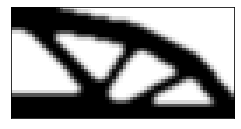

In [68]:
fig, ax = plt.subplots(figsize=(4,3),subplot_kw={'xticks': [], 'yticks': []})
ax.imshow(ds_vcnn3_mbb.design.sel(step=100), cmap='Greys')

<xarray.DataArray 'loss' ()>
array(201.0086369)
Coordinates:
    step     int64 100


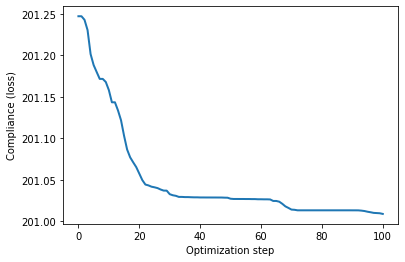

In [124]:
ds_vcnn3_mbb.loss.transpose().to_pandas().cummin().loc[:100].plot(linewidth=2)
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
print(ds_vcnn3_mbb.loss.sel(step=100))

In [111]:
def loss0(model, logits):
    # for our neural network, we use float32, but we use float64 for the physics
    # to avoid any chance of overflow.
    # add 0.0 to work-around bug in grad of tf.cast on NumPy arrays
    kl_loss = tf.math.square(model.z_mean) + tf.math.exp(model.z_log_sigma) - model.z_log_sigma - 1
    kl_loss = tf.math.reduce_sum(kl_loss)
    kl_loss *= 0.5
    losses = kl_loss
    return tf.reduce_mean(losses)

In [133]:
def compliance(model):
    output = model.core_model([model.z_mean, model.z_log_sigma])
    return model.loss(output).numpy() - loss0(vcnn3_mbb, output).numpy()
compliance(vcnn3_mbb)

85.65417523418466

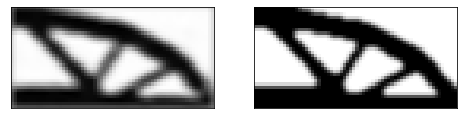

In [77]:
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(np.squeeze(output), cmap='Greys')
ax[1].imshow(vcnn3_mbb.env.render(np.squeeze(output), volume_contraint=True), cmap='Greys')

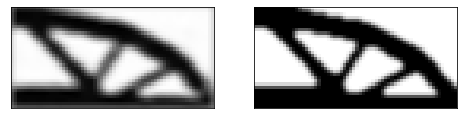

In [84]:
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(np.squeeze(output), cmap='Greys')
ax[1].imshow(vcnn3_mbb.env.render(np.squeeze(output), volume_contraint=True), cmap='Greys')

In [100]:
vcnn3_mbb = VarCNNModel(args=args_mbb, resizes=(1,2,1), conv_filters=(32,16,1))

In [101]:
save_dir = os.path.join(cur_file_dir,'saved_models')
vcnn3_mbb.save_weights(os.path.join(save_dir,'vcnn3_mbb_weights'+'0'))

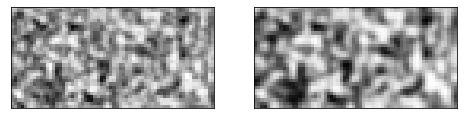

In [102]:
# new_model.load_weights(os.path.join(save_dir,'vcnn3_mbb_weights'+'0'))
# output = new_model.core_model([new_model.z_mean, new_model.z_log_sigma])
# fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
# ax[0].imshow(np.squeeze(output), cmap='Greys')
# ax[1].imshow(new_model.env.render(np.squeeze(output), volume_contraint=True), cmap='Greys')

In [103]:
for i in range(10):
    train.train_lbfgs(vcnn3_mbb, 10)
    vcnn3_mbb.save_weights(os.path.join(save_dir,'vcnn3_mbb_weights{}'.format(10*(i+1))))

The following Variables were used a Lambda layer's call (tf.math.exp_7), but
are not present in its tracked objects:
  <tf.Variable 'z_log_sigma:0' shape=(128,) dtype=float32, numpy=
array([ 2.2484925 ,  0.90279275,  0.0197296 ,  0.23634218, -1.0689381 ,
       -1.5833722 , -0.05978004, -0.06956444, -1.4421335 ,  1.2424589 ,
       -1.457495  ,  1.5171167 ,  0.6944895 ,  0.2677406 , -1.1551929 ,
        0.38042578,  1.2987982 , -0.8554239 , -1.4480004 , -0.89078647,
        1.0185627 ,  0.38330474,  0.8892746 , -1.3160962 ,  2.1736233 ,
        0.48088318, -0.9014539 ,  0.4615572 , -0.04561593,  1.2122836 ,
       -2.154084  , -1.6328477 , -0.06000441,  1.5258665 ,  0.0393086 ,
       -0.47266042, -0.2948239 ,  0.27158096, -1.3937824 ,  1.0565803 ,
        0.1757087 ,  2.8013504 , -3.216813  ,  0.2933941 ,  0.53339267,
       -0.97758013, -1.5436505 , -0.10499326,  0.3427134 , -0.15692274,
       -1.3210424 , -1.3384666 ,  2.4017334 ,  0.02390691,  0.35295865,
        0.04981258,  0.34

The following Variables were used a Lambda layer's call (tf.math.exp_7), but
are not present in its tracked objects:
  <tf.Variable 'z_log_sigma:0' shape=(128,) dtype=float32, numpy=
array([ 2.2484925 ,  0.90279275,  0.0197296 ,  0.23634218, -1.0689381 ,
       -1.5833722 , -0.05978004, -0.06956444, -1.4421335 ,  1.2424589 ,
       -1.457495  ,  1.5171167 ,  0.6944895 ,  0.2677406 , -1.1551929 ,
        0.38042578,  1.2987982 , -0.8554239 , -1.4480004 , -0.89078647,
        1.0185627 ,  0.38330474,  0.8892746 , -1.3160962 ,  2.1736233 ,
        0.48088318, -0.9014539 ,  0.4615572 , -0.04561593,  1.2122836 ,
       -2.154084  , -1.6328477 , -0.06000441,  1.5258665 ,  0.0393086 ,
       -0.47266042, -0.2948239 ,  0.27158096, -1.3937824 ,  1.0565803 ,
        0.1757087 ,  2.8013504 , -3.216813  ,  0.2933941 ,  0.53339267,
       -0.97758013, -1.5436505 , -0.10499326,  0.3427134 , -0.15692274,
       -1.3210424 , -1.3384666 ,  2.4017334 ,  0.02390691,  0.35295865,
        0.04981258,  0.34

The following Variables were used a Lambda layer's call (tf.__operators__.add_28), but
are not present in its tracked objects:
  <tf.Variable 'z_mean:0' shape=(128,) dtype=float32, numpy=
array([-1.1745497 , -0.68305796, -0.22088325,  1.9310919 , -0.5113529 ,
       -0.55773914, -0.71247417,  0.26182452,  0.72406244,  1.5630277 ,
       -1.1230311 ,  0.26444483,  1.8283516 , -0.8555972 ,  2.390406  ,
       -1.6202667 , -0.32212353, -1.1718578 ,  0.39466596,  0.15096365,
        0.54835874, -0.36744577, -0.5116791 ,  0.16232497, -0.9064029 ,
        0.19415109, -0.30467162,  0.21197519, -0.44896916,  1.1787275 ,
        0.1352952 ,  0.8726086 , -0.2925016 , -0.79607815, -0.43344873,
       -1.0307914 , -0.00822584,  0.8104177 , -1.1674776 , -0.8298766 ,
        0.95470256, -0.19905384,  0.5917586 ,  0.20747846, -0.09683324,
       -0.39227185, -1.6449445 ,  0.11770688,  0.3857491 , -0.506864  ,
       -0.8135517 , -0.5582981 , -1.7987062 , -0.89704657, -1.3036456 ,
       -0.69424003, 

The following Variables were used a Lambda layer's call (tf.__operators__.add_28), but
are not present in its tracked objects:
  <tf.Variable 'z_mean:0' shape=(128,) dtype=float32, numpy=
array([-1.1745497 , -0.68305796, -0.22088325,  1.9310919 , -0.5113529 ,
       -0.55773914, -0.71247417,  0.26182452,  0.72406244,  1.5630277 ,
       -1.1230311 ,  0.26444483,  1.8283516 , -0.8555972 ,  2.390406  ,
       -1.6202667 , -0.32212353, -1.1718578 ,  0.39466596,  0.15096365,
        0.54835874, -0.36744577, -0.5116791 ,  0.16232497, -0.9064029 ,
        0.19415109, -0.30467162,  0.21197519, -0.44896916,  1.1787275 ,
        0.1352952 ,  0.8726086 , -0.2925016 , -0.79607815, -0.43344873,
       -1.0307914 , -0.00822584,  0.8104177 , -1.1674776 , -0.8298766 ,
        0.95470256, -0.19905384,  0.5917586 ,  0.20747846, -0.09683324,
       -0.39227185, -1.6449445 ,  0.11770688,  0.3857491 , -0.506864  ,
       -0.8135517 , -0.5582981 , -1.7987062 , -0.89704657, -1.3036456 ,
       -0.69424003, 

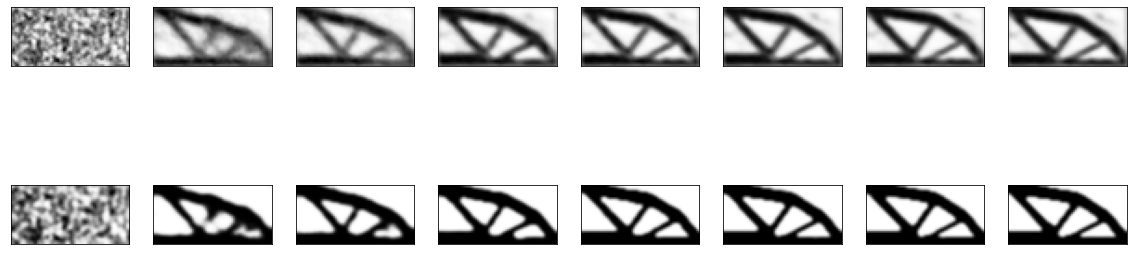

In [209]:
fig, ax = plt.subplots(2, 8, figsize=(20,6),subplot_kw={'xticks': [], 'yticks': []})
for i in range(8):
    new_model.load_weights(os.path.join(save_dir,'vcnn3_mbb_weights{}'.format(10*(i))))
    output = new_model.core_model([new_model.z_mean, new_model.z_log_sigma])
    ax[0, i].imshow(np.squeeze(output), cmap='Greys')
    ax[1, i].imshow(new_model.env.render(np.squeeze(output), volume_contraint=True), cmap='Greys')

## MBB beam with larger grid

In [127]:
problem_mbb2 = problems.mbb_beam(width=192, height=64, density=0.5)
args_mbb2 = topo_api.specified_task(problem_mbb2)

In [128]:
vcnn3_mbb2 = VarCNNModel(args=args_mbb2, resizes=(1,2,1), conv_filters=(32,16,1))

In [129]:
ds_vcnn3_mbb2 = train.train_lbfgs(vcnn3_mbb2, 100)

The following Variables were used a Lambda layer's call (tf.math.exp_8), but
are not present in its tracked objects:
  <tf.Variable 'z_log_sigma:0' shape=(128,) dtype=float32, numpy=
array([ 2.2484925 ,  0.90279275,  0.0197296 ,  0.23634218, -1.0689381 ,
       -1.5833722 , -0.05978004, -0.06956444, -1.4421335 ,  1.2424589 ,
       -1.457495  ,  1.5171167 ,  0.6944895 ,  0.2677406 , -1.1551929 ,
        0.38042578,  1.2987982 , -0.8554239 , -1.4480004 , -0.89078647,
        1.0185627 ,  0.38330474,  0.8892746 , -1.3160962 ,  2.1736233 ,
        0.48088318, -0.9014539 ,  0.4615572 , -0.04561593,  1.2122836 ,
       -2.154084  , -1.6328477 , -0.06000441,  1.5258665 ,  0.0393086 ,
       -0.47266042, -0.2948239 ,  0.27158096, -1.3937824 ,  1.0565803 ,
        0.1757087 ,  2.8013504 , -3.216813  ,  0.2933941 ,  0.53339267,
       -0.97758013, -1.5436505 , -0.10499326,  0.3427134 , -0.15692274,
       -1.3210424 , -1.3384666 ,  2.4017334 ,  0.02390691,  0.35295865,
        0.04981258,  0.34

The following Variables were used a Lambda layer's call (tf.math.exp_8), but
are not present in its tracked objects:
  <tf.Variable 'z_log_sigma:0' shape=(128,) dtype=float32, numpy=
array([ 2.2484925 ,  0.90279275,  0.0197296 ,  0.23634218, -1.0689381 ,
       -1.5833722 , -0.05978004, -0.06956444, -1.4421335 ,  1.2424589 ,
       -1.457495  ,  1.5171167 ,  0.6944895 ,  0.2677406 , -1.1551929 ,
        0.38042578,  1.2987982 , -0.8554239 , -1.4480004 , -0.89078647,
        1.0185627 ,  0.38330474,  0.8892746 , -1.3160962 ,  2.1736233 ,
        0.48088318, -0.9014539 ,  0.4615572 , -0.04561593,  1.2122836 ,
       -2.154084  , -1.6328477 , -0.06000441,  1.5258665 ,  0.0393086 ,
       -0.47266042, -0.2948239 ,  0.27158096, -1.3937824 ,  1.0565803 ,
        0.1757087 ,  2.8013504 , -3.216813  ,  0.2933941 ,  0.53339267,
       -0.97758013, -1.5436505 , -0.10499326,  0.3427134 , -0.15692274,
       -1.3210424 , -1.3384666 ,  2.4017334 ,  0.02390691,  0.35295865,
        0.04981258,  0.34

The following Variables were used a Lambda layer's call (tf.__operators__.add_32), but
are not present in its tracked objects:
  <tf.Variable 'z_mean:0' shape=(128,) dtype=float32, numpy=
array([-1.1745497 , -0.68305796, -0.22088325,  1.9310919 , -0.5113529 ,
       -0.55773914, -0.71247417,  0.26182452,  0.72406244,  1.5630277 ,
       -1.1230311 ,  0.26444483,  1.8283516 , -0.8555972 ,  2.390406  ,
       -1.6202667 , -0.32212353, -1.1718578 ,  0.39466596,  0.15096365,
        0.54835874, -0.36744577, -0.5116791 ,  0.16232497, -0.9064029 ,
        0.19415109, -0.30467162,  0.21197519, -0.44896916,  1.1787275 ,
        0.1352952 ,  0.8726086 , -0.2925016 , -0.79607815, -0.43344873,
       -1.0307914 , -0.00822584,  0.8104177 , -1.1674776 , -0.8298766 ,
        0.95470256, -0.19905384,  0.5917586 ,  0.20747846, -0.09683324,
       -0.39227185, -1.6449445 ,  0.11770688,  0.3857491 , -0.506864  ,
       -0.8135517 , -0.5582981 , -1.7987062 , -0.89704657, -1.3036456 ,
       -0.69424003, 

The following Variables were used a Lambda layer's call (tf.__operators__.add_32), but
are not present in its tracked objects:
  <tf.Variable 'z_mean:0' shape=(128,) dtype=float32, numpy=
array([-1.1745497 , -0.68305796, -0.22088325,  1.9310919 , -0.5113529 ,
       -0.55773914, -0.71247417,  0.26182452,  0.72406244,  1.5630277 ,
       -1.1230311 ,  0.26444483,  1.8283516 , -0.8555972 ,  2.390406  ,
       -1.6202667 , -0.32212353, -1.1718578 ,  0.39466596,  0.15096365,
        0.54835874, -0.36744577, -0.5116791 ,  0.16232497, -0.9064029 ,
        0.19415109, -0.30467162,  0.21197519, -0.44896916,  1.1787275 ,
        0.1352952 ,  0.8726086 , -0.2925016 , -0.79607815, -0.43344873,
       -1.0307914 , -0.00822584,  0.8104177 , -1.1674776 , -0.8298766 ,
        0.95470256, -0.19905384,  0.5917586 ,  0.20747846, -0.09683324,
       -0.39227185, -1.6449445 ,  0.11770688,  0.3857491 , -0.506864  ,
       -0.8135517 , -0.5582981 , -1.7987062 , -0.89704657, -1.3036456 ,
       -0.69424003, 

In [138]:
cnn3_mbb2 = models.CNNModel(args=args_mbb2, resizes=(1,2,1), conv_filters=(32,16,1))

In [139]:
ds_cnn3_mbb2 = train.train_lbfgs(cnn3_mbb2, 100)

In [167]:
print('compliance of vcnn {:.2f}'.format(compliance(vcnn3_mbb2)))
print('compliance of cnn {:.2f}'.format(ds_cnn3_mbb2.loss.to_numpy()[-1]))

compliance of vcnn 200.81
compliance of cnn 202.75


<xarray.DataArray 'loss' ()>
array(202.90072631)
Coordinates:
    step     int64 100


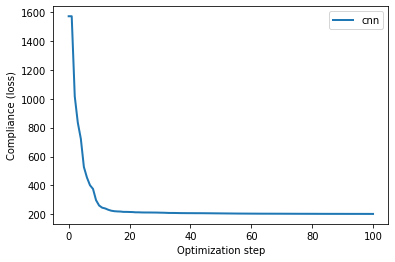

In [151]:
ds_cnn3_mbb2.loss.transpose().to_pandas().cummin().loc[:100].plot(linewidth=2, label='cnn')
plt.ylabel('Compliance (loss)')
plt.xlabel('Optimization step')
plt.legend()
print(ds_cnn3_mbb2.loss.sel(step=100))

Text(0.5, 1.0, 'cnn')

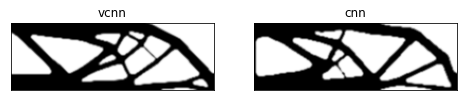

In [172]:
fig, ax = plt.subplots(1, 2, figsize=(8,12),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(ds_vcnn3_mbb2.design.sel(step=100), cmap='Greys')
ax[0].set_title('vcnn')
ax[1].imshow(ds_cnn3_mbb2.design.sel(step=100), cmap='Greys')
ax[1].set_title('cnn')

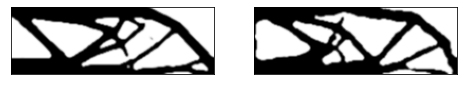

In [206]:
output = vcnn3_mbb2.env.render(
    np.squeeze(vcnn3_mbb2.core_model([vcnn3_mbb2.z_mean, tf.random.normal(shape=vcnn3_mbb2.z_log_sigma.shape, mean=0.0, stddev=1)])),
    volume_contraint=True)
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(output, cmap='Greys')
output = cnn3_mbb2.env.render(
    np.squeeze(cnn3_mbb2.core_model([cnn3_mbb2.z+tf.random.normal(shape=cnn3_mbb2.z.shape, mean=0.0, stddev=1)])),
    volume_contraint=True)
ax[1].imshow(output, cmap='Greys')

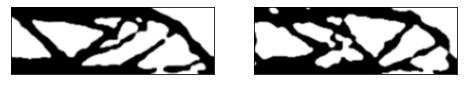

In [207]:
output = vcnn3_mbb2.env.render(
    np.squeeze(vcnn3_mbb2.core_model([vcnn3_mbb2.z_mean, tf.random.normal(shape=vcnn3_mbb2.z_log_sigma.shape, mean=0.0, stddev=2)])),
    volume_contraint=True)
fig, ax = plt.subplots(1, 2, figsize=(8,6),subplot_kw={'xticks': [], 'yticks': []})
ax[0].imshow(output, cmap='Greys')
output = cnn3_mbb2.env.render(
    np.squeeze(cnn3_mbb2.core_model([cnn3_mbb2.z+tf.random.normal(shape=cnn3_mbb2.z.shape, mean=0.0, stddev=2)])),
    volume_contraint=True)
ax[1].imshow(output, cmap='Greys')